## Importing dataset and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing

# Load dataset
housing = fetch_california_housing(as_frame=True)
df = housing.frame
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## EDA on dataset

In [2]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


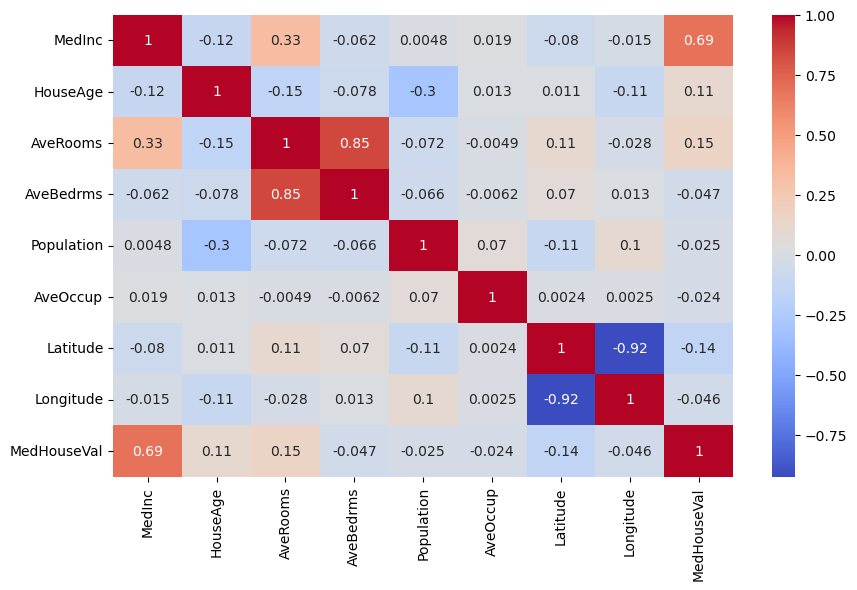

In [3]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()


## Data Pre-processing

There doesn't seem to be any null values that need to be imputed

In [4]:
df.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features = df.drop('MedHouseVal', axis=1)
scaled_features = scaler.fit_transform(features)

X = pd.DataFrame(scaled_features, columns=features.columns)
y = df['MedHouseVal']


## Train-Test split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Model Training and saving

In [11]:
import os
import joblib

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Create 'models' directory if it doesn't exist
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

In [12]:
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "NeuralNetwork": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Ridge": Ridge(alpha=1.0)
}

# Fit each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)  # X_train, y_train are your training data
    # Save the model to disk
    joblib.dump(model, os.path.join(model_dir, f"{name}.pkl"))
    print(f"{name} model saved as {name}.pkl\n")


Training LinearRegression...
LinearRegression model saved as LinearRegression.pkl

Training DecisionTree...
DecisionTree model saved as DecisionTree.pkl

Training NeuralNetwork...
NeuralNetwork model saved as NeuralNetwork.pkl

Training XGBoost...
XGBoost model saved as XGBoost.pkl

Training Ridge...
Ridge model saved as Ridge.pkl



In [18]:
import json
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Dictionary to hold evaluation metrics
evaluation_results = {}

def evaluate_model(name, model, X_test, y_test):
    preds = model.predict(X_test)
    rmse = float(np.sqrt(mean_squared_error(y_test, preds)))
    mae = float(mean_absolute_error(y_test, preds))
    r2 = float(r2_score(y_test, preds))
    
    # Store metrics in dictionary
    evaluation_results[name] = {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    }

# Assuming 'models' is a dict of model_name:model_object
for name, model in models.items():
    evaluate_model(name, model, X_test, y_test)

# Print results to confirm they look correct
for m_name, metrics in evaluation_results.items():
    print(m_name, metrics)

# Finally, store the evaluation_results dictionary into a JSON file
json_file_path = "evaluation_results.json"

with open(json_file_path, "w") as json_file:
    json.dump(evaluation_results, json_file, indent=4)

print(f"Evaluation metrics successfully saved to {json_file_path}")


LinearRegression {'RMSE': 0.7455813830127762, 'MAE': 0.5332001304956565, 'R2': 0.575787706032451}
DecisionTree {'RMSE': 0.7030445773467542, 'MAE': 0.4537843265503876, 'R2': 0.6228111330554302}
NeuralNetwork {'RMSE': 0.5072218293125931, 'MAE': 0.3387485704888966, 'R2': 0.8036689396950109}
XGBoost {'RMSE': 0.4717943691423984, 'MAE': 0.30957335413783094, 'R2': 0.8301370561019205}
Ridge {'RMSE': 0.7455542909384607, 'MAE': 0.5331933646313114, 'R2': 0.5758185345441323}
Evaluation metrics successfully saved to evaluation_results.json


In [14]:
joblib.dump(scaler, f"{model_dir}/scaler.pkl")

['models/scaler.pkl']